![QuantConnect Logo](https://cdn.quantconnect.com/web/i/icon.png)
<hr>

# Introduction
This notebook illustrates how applying various pre-processing techniques to factors values can impact the accuracy of a machine learning model. The model used here is a random forest from the `lightgbm` Python package.

# Part 1: Get Raw Data
Gather some raw data so you can train and test the model. Start with the producing the label, which is 1 if the future weekly return for SPY market index from open to open is positive, otherwise it's 0.

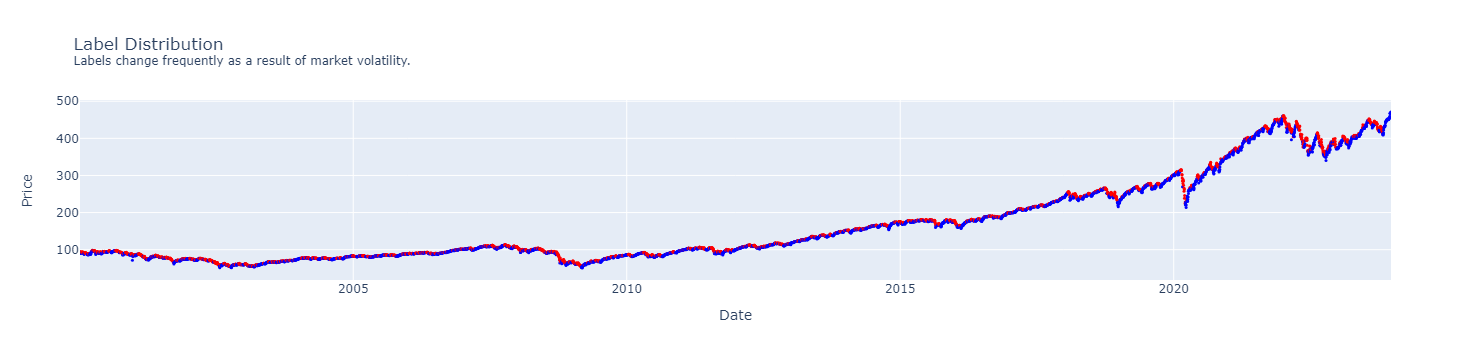

time
2000-01-03 16:00:00    0
2000-01-04 16:00:00    1
2000-01-05 16:00:00    1
2000-01-06 16:00:00    1
2000-01-07 16:00:00    1
                      ..
2023-12-15 16:00:00    1
2023-12-18 16:00:00    1
2023-12-19 16:00:00    1
2023-12-20 16:00:00    1
2023-12-21 16:00:00    1
Name: open, Length: 6032, dtype: int64
open
1    3492
0    2540
Name: count, dtype: int64


In [1]:
import plotly.graph_objects as go

# Create a QuantBook.
qb = QuantBook()
# Add the asset.
symbol = qb.add_equity("SPY", Resolution.DAILY).symbol
# Get the asset history.
history = qb.history(symbol, datetime(2000, 1, 1), datetime(2024, 1, 1))
# Calculate the labels.
label = history.loc[symbol]['open'].pct_change(5).shift(-5).dropna().apply(
    lambda x: int(x > 0)
)
# Show the result.
go.Figure(
    go.Scatter(
        x=label.index, y=history.loc[symbol]['open'], mode='markers', 
        marker=dict(
            color=['blue' if x else 'red' for x in label.values], size=3
        )
    ),
    dict(
        title="Label Distribution<br><sup>Labels change frequently "
            + "as a result of market volatility.</sup>", 
        xaxis_title="Date", yaxis_title="Price", 
        xaxis={'range': [label.index[0], label.index[-1]]}
    )
).show()
print(label)
print(label.value_counts())

Next, define the factors you'll input into the model to predict the label. For demonstration purposes, use random factors.

In [2]:
np.random.seed(2)
num_factors = 4
num_samples = len(label)
factors = np.random.rand(num_samples, num_factors)
# Make one of the factors non-stationary.
factors[:, -1] = factors[:, -1].cumsum()
factors

array([[4.35994902e-01, 2.59262318e-02, 5.49662478e-01, 4.35322393e-01],
       [4.20367802e-01, 3.30334821e-01, 2.04648634e-01, 1.05459336e+00],
       [2.99654674e-01, 2.66827275e-01, 6.21133833e-01, 1.58373545e+00],
       ...,
       [3.60844089e-01, 5.74694384e-01, 2.69815017e-02, 3.01542656e+03],
       [7.13394113e-01, 9.23464540e-01, 7.01197399e-01, 3.01615350e+03],
       [9.74388250e-01, 4.67552055e-01, 2.70561879e-01, 3.01703146e+03]])

# Part 2: Test Model Accuracy Using Raw Factors
The next code block defines a method to train and test the model. The method below uses 75% of the data to train it and leaves 25% of the data for the out-of-sample test. Let's see how the model performs with just the raw factor values. The number that the method returns represents the percentage of samples in the out-of-sample dataset that the model predicted the correct label. The method also displays a line plot showing the probability that the model predicts for each possible label (0 or 1) for each sample in the tst set. The factors are random, but there are more labels of class 1 than class 0, so we should expect the model to give a greater probability to class 1 for each prediction and we should expect an accuracy slightly greater than 50%.

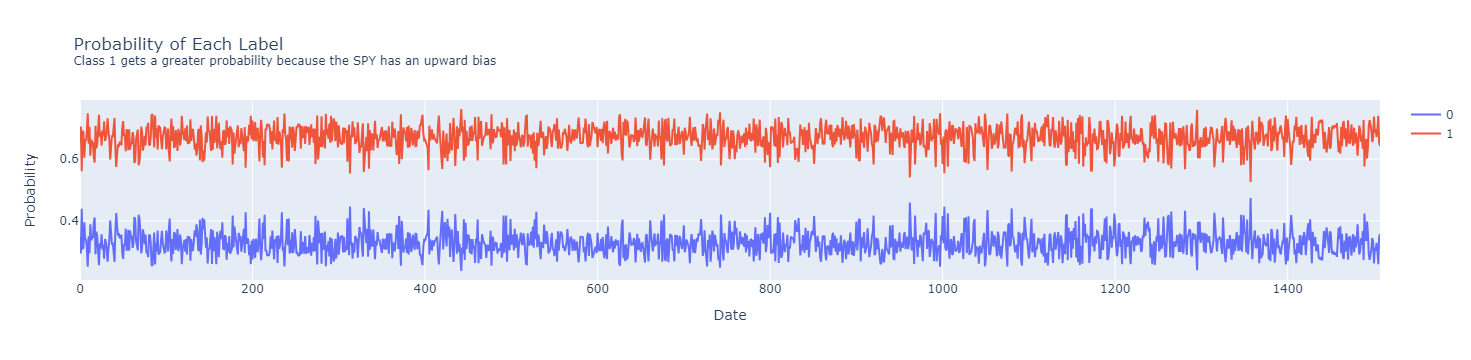

Accuracy: 0.6101


In [3]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def oos_accuracy(factors, label):
    X_train, X_test, y_train, y_test = train_test_split(
        factors, label, test_size=0.25, shuffle=False
    )
    model = lgb.train(
        {
            'seed' : 1234, 
            'verbose': -1, 
            'boosting_type': 'rf', 
            'feature_fraction': 0.8, 
            'objective': 'multiclass', 
            'num_class': 2, 
            'bagging_freq': 5, 
            'bagging_fraction': 0.8,
            'is_unbalanced': True
        }, 
        train_set=lgb.Dataset(
            data=X_train, label=y_train, free_raw_data=True
        ).construct()
    )
    predictions = model.predict(X_test)
    x = list(range(len(predictions)))
    go.Figure(
        [
            go.Scatter(x=x, y=predictions[:, 0], name=0),
            go.Scatter(x=x, y=predictions[:, 1], name=1)
        ],
        dict(
            title="Probability of Each Label<br><sup>Class 1 gets a greater "
                + "probability because the SPY has an upward bias</sup>", 
            xaxis_title="Date", yaxis_title="Probability"
        )
    ).show()
    y_hat = predictions.argmax(axis=1)
    print(f"Accuracy: {round(accuracy_score(y_hat, y_test), 4)}")

oos_accuracy(factors, label)

# Part 3: Test Model Accuracy Using Stationary Factors

Lopez de Prado explains that "supervised learning algorithms typically require stationary features" (2018, p. 76). Let's perform an Augmented Dickey–Fuller test to see if our factors are stationary at the 95% confidence level.

### Test Factor Stationarity

In [4]:
from statsmodels.tsa.stattools import adfuller

for factor_idx in range(num_factors):
    factor = factors[:, factor_idx]
    test_results = adfuller(factor, maxlag=1, regression='c', autolag=None)
    # Check the p-value.
    output = "Stationary" if test_results[1] <= 0.05 else "Not stationary"
    print(f"Factor {factor_idx}: {output}")

Factor 0: Stationary
Factor 1: Stationary
Factor 2: Stationary
Factor 3: Not stationary


### Adjust Factor Values to Achieve Stationarity
If the raw factors aren't stationary, you can transform them to make them stationary. Lopez de Prado mentions that "virutally all finance papers attempt to recover stationarity by applying an integer differentiation. . ., which means that most studies have over-differentiated the series, that is, they have removed much more memory than was necessary to statisfy standard econometric assumptions" (2018, p. 76). To avoid over-differentiating the factors, you can use Lopez de Prado's fractional differentiation technique. The following code is from Lopez de Prado (2018, pp. 79-84):

In [5]:
def get_weights_ffd(d, thres):
    '''
    Computing the weights for differentiating the series with fixed 
    window size
    
        Parameters:
            d (float): differentiating factor
            thres (float): threshold for cutting off weights
            
        Returns:
            w (np.ndarray): array contatining weights
    '''
    w, k = [1.0], 1
    while True:
        w_ = -w[-1] / k * (d - k + 1)
        if abs(w_) < thres:
            break
        w.append(w_)
        k += 1
    w = np.array(w[::-1]).reshape(-1, 1)
    return w

def frac_diff_ffd(series, d, thres=1e-5):
    '''
    Fractional differentiation with constant width window
    Note 1: thres determines the cut-off weight for the window
    Note 2: d can be any positive fractional, not necessarily bounded 
    [0,1]
    
        Parameters:
            series (pd.DataFrame): dataframe with time series
            d (float): differentiating factor
            thres (float): threshold for cutting off weights
        
        Returns:
            df (pd.DataFrame): dataframe with differentiated series
    '''
    w = get_weights_ffd(d, thres)
    width = len(w) - 1

    df = {}
    for name in series.columns:
        series_f = series[[name]].ffill().dropna()
        df_ = pd.Series(index=np.arange(series.shape[0]), dtype=object)
        for iloc1 in range(width, series_f.shape[0]):
            loc0, loc1 = series_f.index[iloc1 - width], series_f.index[iloc1]
            if not np.isfinite(series.loc[loc1, name]):
                continue    # exclude NAs
            df_[loc1] = np.dot(w.T, series_f.loc[loc0:loc1])[0, 0]
        df[name] = df_.dropna().copy(deep=True)
    df = pd.concat(df, axis=1)
    return df

def ffd(process, thres=0.01):
    '''
    Finding the minimum differentiating factor that passes the ADF test
    
        Parameters:
            process (np.ndarray): array with random process values
            apply_constant_width (bool): flag that shows whether to use 
             constant width window (if True) or increasing width window 
             (if False)
            thres (float): threshold for cutting off weights
    '''    
    for d in np.linspace(0, 1, 11):
        process_diff = frac_diff_ffd(pd.DataFrame(process), d, thres)
        test_results = adfuller(
            process_diff[process.name], maxlag=1, regression='c', autolag=None
        )
        if test_results[1] <= 0.05:
            break
    return process_diff[process.name]

stationary_factors = pd.DataFrame()
for factor_idx in range(num_factors):
    stationary_factors[factor_idx] = ffd(
        pd.Series(factors[:, factor_idx], name=factor_idx)
    )
stationary_factors

0         1         2         3
0     0.435995  0.025926  0.549662       NaN
1     0.420368  0.330335  0.204649  0.619271
2     0.299655  0.266827  0.621134  0.529142
3      0.13458  0.513578   0.18444  0.785335
4     0.853975  0.494237  0.846561  0.079645
...        ...       ...       ...       ...
6027  0.872775  0.974867  0.443859  0.367751
6028  0.592965  0.722177  0.840071  0.931549
6029  0.360844  0.574694  0.026982  0.073037
6030  0.713394  0.923465  0.701197  0.726944
6031  0.974388  0.467552  0.270562  0.877962

[6032 rows x 4 columns]

### Test Accuracy
Let's now test the out-of-sample accuracy of the model when using the stationary factors.

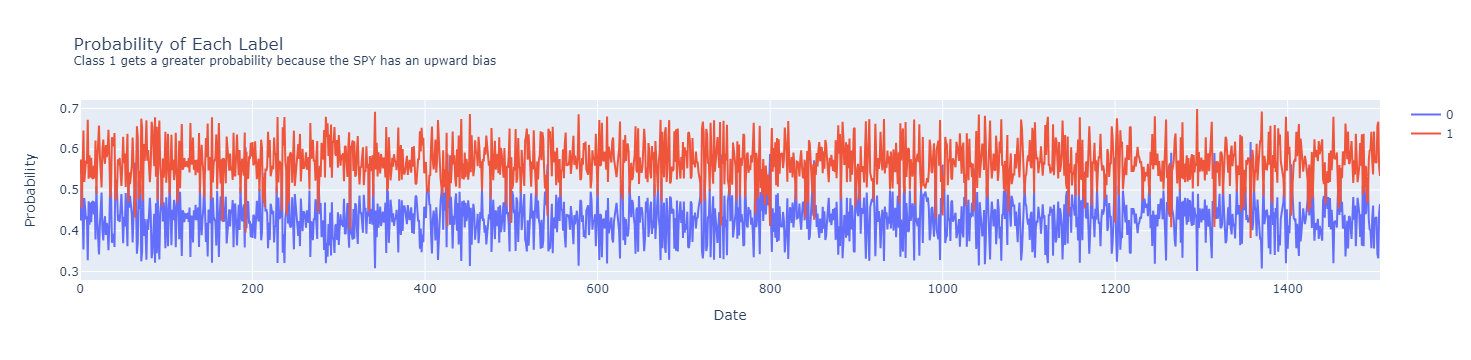

Accuracy: 0.5849


In [6]:
oos_accuracy(stationary_factors.values, label)

# Part 4: Test Model Accuracy Using Standardized Factors

Another common preproccessing technique is standardization, which transforms the factor values to be normally distributed. Let's try it.

### Standardize Factors Values


In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
standardized_factors = scaler.fit_transform(stationary_factors)
standardized_factors

array([[-0.2118898 , -1.62557496,  0.16731626,         nan],
       [-0.26646686, -0.57598345, -1.02392211,  0.40793833],
       [-0.68805291, -0.79495553,  0.41408729,  0.09920322],
       ...,
       [-0.47435118,  0.26656084, -1.63735809, -1.46317669],
       [ 0.75691647,  1.46910967,  0.69052487,  0.77676957],
       [ 1.66842865, -0.10286263, -0.79634172,  1.29407983]])

### Test Accuracy
Now that you have the standardized factors, use them to test the model's out-of-sample accuracy.

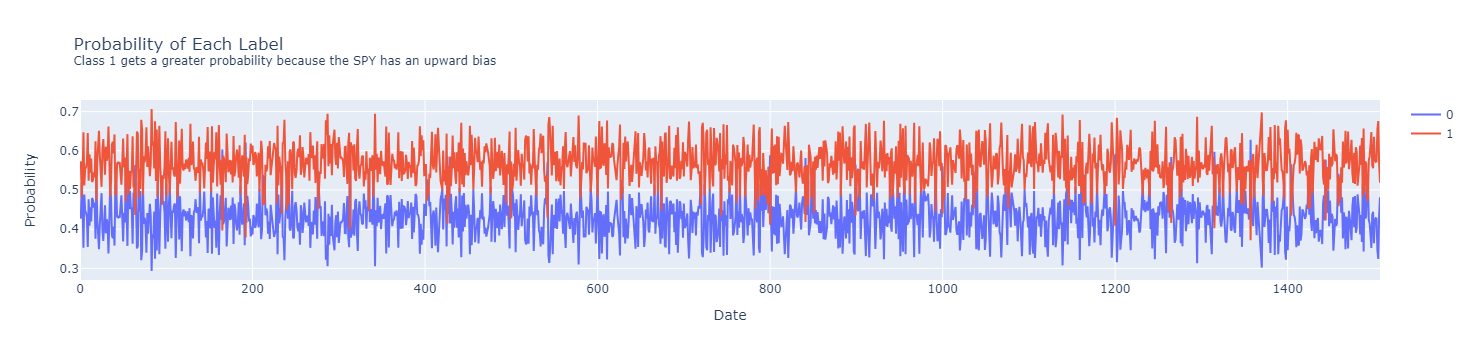

Accuracy: 0.5882


In [8]:
oos_accuracy(standardized_factors, label)

# Part 5: Test Model Accuracy Using Principal Components
Principal component analysis (PCA) is another common preprocessing technique that can reduce the dimensionality of the factors. PCA performs best when the factors are on the same scale ([reference](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html)), so in this case, perform PCA on the standardized factors.

### Perform PCA

In [9]:
from sklearn.decomposition import PCA

pca = PCA(random_state=0)
principal_components = pca.fit_transform(standardized_factors[1:, :])
principal_components

array([[ 0.71937564,  0.73967869,  0.58117998,  0.46418545],
       [-0.29381624,  0.63600662,  0.55587191, -0.69810788],
       [-0.05409614,  0.70343508,  1.41599867,  1.1179195 ],
       ...,
       [ 1.57090748, -1.14037956,  1.14012643,  0.22267919],
       [-1.12873034, -0.55103043, -1.14410629,  0.96122248],
       [ 0.67953249,  0.9743579 , -1.44458953,  1.26686822]])

### Test Accuracy

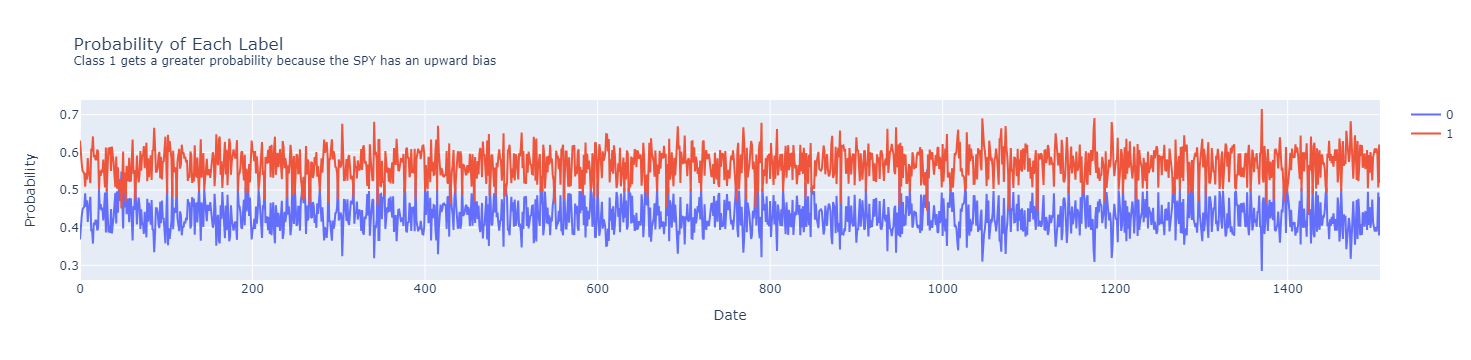

Accuracy: 0.5962


In [10]:
oos_accuracy(principal_components, label.iloc[1:])